# Чтение данных

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud
#import nltk
#from nltk.corpus import stopwords

In [9]:
filename = 'geo-reviews-dataset-2023.tskv'

all_records = []

with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
        if not line.strip():
            continue
            
        record_dict = {}
        
        pairs = line.strip().split('\t')
        
        for pair in pairs:
            try:
                key, value = pair.split('=', 1)
                record_dict[key] = value
            except ValueError:
                pass
                
        all_records.append(record_dict)

df = pd.DataFrame(all_records)

df.head()


,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


# EDA

Посмотрим на состав данных

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  500000 non-null  object
 1   name_ru  499030 non-null  object
 2   rating   500000 non-null  object
 3   rubrics  500000 non-null  object
 4   text     500000 non-null  object
dtypes: object(5)
memory usage: 19.1+ MB


## Преобразование типов

In [25]:
df['rating'] = pd.to_numeric(df['rating'])
df['rating'].value_counts(dropna=False)

rating
5.0    390515
4.0     41160
1.0     34351
3.0     21686
2.0     12088
0.0       200
Name: count, dtype: int64

## Заполнение пропусков

Видим, что у 970 отзывов нет названия организаций, посмотрим на эти данные

In [ ]:
df[df['name_ru'].isna()]

,address,name_ru,rating,rubrics,text
322,"Москва, 8-я улица Соколиной Горы, 15А, стр. 23",NaN,5.,Офис организации,"Ребята профи!\n\nОтлично подобрали модель, съе..."
5716,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.,Гостиница,"Гостиница действительно хорошая, удобно распол..."
5717,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.,Гостиница,Был здесь на кулинарном мастер-классе. Место а...
5718,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.,Гостиница,"Тихое место, в выходные возможно и шумно так к..."
5719,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.,Гостиница,"Воспитанные и отзывчивые официанты , вкусная к..."
...,...,...,...,...,...
498536,"Республика Башкортостан, Уфа, улица Менделеева...",NaN,5.,"Скалодром;Спортивный клуб, секция",Были с детьми на 8 марта. Приехали специально ...
498688,"Москва, Юго-Восточный административный округ, ...",NaN,5.,Изготовление памятников и надгробий;Изделия из...,"Отличное качество материала, прекрасное исполн..."
498913,"Самарская область, Волжский район, жилой район...",NaN,1.,Магазин цветов;Копировальный центр;Товары для ...,"Цен на цветы которые находятся на витрине нет,..."
499006,"Волгоград, улица Гроссмана, 6",NaN,5.,Салон красоты,Квалифицированные мастера. Работу выполняют с ...


Судя по адресам таких организаций 576 - вручную найти и проставить названия будет сложно

In [18]:
df[df['name_ru'].isna()]['address'].value_counts()

address
Новгородская область, 49Н-1234                                                                16
Санкт-Петербург, улица Рентгена, 19                                                           16
Республика Карелия, Петрозаводск, улица Федосовой, 30                                         13
Краснодарский край, Сочи, микрорайон Центральный, Навагинская улица, 11, корп. 5              12
Новгородская область, Окуловский район, Турбинное сельское поселение, М-11, 423-й километр    11
                                                                                              ..
Москва, Дубининская улица, 67к2                                                                1
Республика Коми, Сыктывкар, Сысольское шоссе, 7/1                                              1
Хабаровск, Морская улица, 7                                                                    1
Ханты-Мансийский автономный округ, Урай, микрорайон Западный, 12Б                              1
Новосибирск, Коммунист

Но мы можем проверить, вдруг есть строки, где адрес проставлен, совпадает рубрика и есть название

In [26]:
df_with_names = df.dropna(subset=['name_ru'])

In [35]:
address_to_name_map = df_with_names.drop_duplicates(subset=['address', 'rubrics']).set_index(['address', 'rubrics'])['name_ru']

In [37]:
address_to_name_map.head()

address                                                                                                           rubrics                                                           
Екатеринбург, ул. Московская / ул. Волгоградская / ул. Печатников                                                 Жилой комплекс                                                        Московский квартал
Московская область, Электросталь, проспект Ленина, 29                                                             Магазин продуктов;Продукты глубокой заморозки;Магазин мяса, колбас     Продукты Ермолино
Краснодар, Прикубанский внутригородской округ, микрорайон имени Петра Метальникова, улица Петра Метальникова, 26  Фитнес-клуб                                                                      LimeFit
Санкт-Петербург, проспект Энгельса, 111, корп. 1                                                                  Пункт проката;Прокат велосипедов;Сапсёрфинг                                 Snow-Express
Тверь, 

In [39]:
address_to_name_map.shape

(272722,)

272 722 известные организации

In [ ]:
rows_to_fill = df['name_ru'].isnull()

0         False
1         False
2         False
3         False
4         False
          ...  
499995    False
499996    False
499997     True
499998    False
499999    False
Name: name_ru, Length: 500000, dtype: bool

In [45]:
df.loc[rows_to_fill, 'address'].map(address_to_name_map).dropna()

Series([], Name: address, dtype: object)

Понимаем, что адреса пустых организаций нигде не повторяются, где названия есть. Так как нам не особо важно название организации, а все остальные данные по ним есть, давайте сгруппируем их по адресу и рубрике (с большой вероятностью это одна и та же организация) и дадим название "Неизвестная организация N" - где N просто номер 

На всякий проверим, что нет организаций с похожими названиями

In [48]:
df[df['name_ru'].str.contains("Неизвестная") == True]

,address,name_ru,rating,rubrics,text


In [52]:
df_without_names = df[df['name_ru'].isna()]
df_without_names['key'] = df['address'] + df['rubrics']
df_without_names.head()

/var/folders/wj/jzwd6lfn7xx02ns8v_wr29bm0000gn/T/ipykernel_25010/3864129646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_names['key'] = df['address'] + df['rubrics']


,address,name_ru,rating,rubrics,text,key
322,"Москва, 8-я улица Соколиной Горы, 15А, стр. 23",NaN,5.0,Офис организации,"Ребята профи!\n\nОтлично подобрали модель, съе...","Москва, 8-я улица Соколиной Горы, 15А, стр. 23..."
5716,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Гостиница действительно хорошая, удобно распол...","Челябинская область, Златоуст, Таганайская ули..."
5717,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,Был здесь на кулинарном мастер-классе. Место а...,"Челябинская область, Златоуст, Таганайская ули..."
5718,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Тихое место, в выходные возможно и шумно так к...","Челябинская область, Златоуст, Таганайская ули..."
5719,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Воспитанные и отзывчивые официанты , вкусная к...","Челябинская область, Златоуст, Таганайская ули..."


In [56]:
unique_missing_keys = df_without_names['key'].unique()
key_to_generated_name_map = {key: f"Неизвестная организация №{i}" for i, key in enumerate(unique_missing_keys, 1)}

In [58]:
df['key'] = df['address'] + df['rubrics']
df.loc[rows_to_fill, 'name_ru'] = df.loc[rows_to_fill, 'key'].map(key_to_generated_name_map)
df.head()

,address,name_ru,rating,rubrics,text,key
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.0,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,"Екатеринбург, ул. Московская / ул. Волгоградск..."
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.0,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...","Московская область, Электросталь, проспект Лен..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.0,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...","Краснодар, Прикубанский внутригородской округ,..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,"Санкт-Петербург, проспект Энгельса, 111, корп...."
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,"Тверь, Волоколамский проспект, 39Салон красоты..."


In [61]:
df = df.drop(columns=['key'])

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   address  500000 non-null  object 
 1   name_ru  500000 non-null  object 
 2   rating   500000 non-null  float64
 3   rubrics  500000 non-null  object 
 4   text     500000 non-null  object 
dtypes: float64(1), object(4)
memory usage: 19.1+ MB


Теперь все данные не пустые

# Аналитика

## Рубрики

In [66]:
df_rubrics = df.copy()
df_rubrics['rubrics_list'] = df_rubrics['rubrics'].str.split(';')

exploded_rubrics = df_rubrics.explode('rubrics_list')

Посмотрим, каких рубрик больше всего

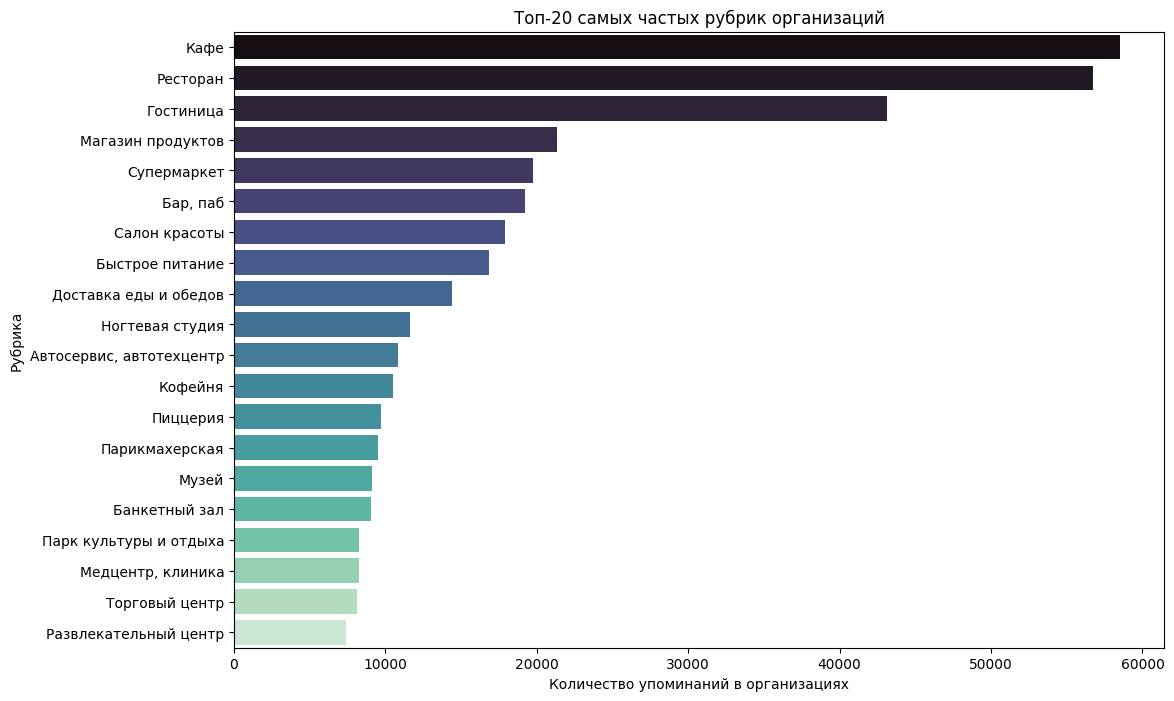

In [87]:
top_rubrics = exploded_rubrics['rubrics_list'].value_counts().nlargest(20)
plt.figure(figsize=(12, 8))
sns.barplot(y=top_rubrics.index, x=top_rubrics.values, palette='mako',  hue=top_rubrics.index)
plt.title('Топ-20 самых частых рубрик организаций')
plt.xlabel('Количество упоминаний в организациях')
plt.ylabel('Рубрика')
plt.show()

И сколько их вообще может быть

In [70]:
len(exploded_rubrics['rubrics_list'].unique())

1370

In [72]:
df.sample(20)

,address,name_ru,rating,rubrics,text
136788,"Ивановская область, Приволжск, улица Куйбышева, 2",Сон & Лён,5.0,Гостиница,"Чисто, аккуратно, уютно, доброжелательный перс..."
251448,"Москва, проезд Серебрякова, 14Б, стр. 4",Стартекс,5.0,Производство и продажа тканей;Текстильная комп...,Шикарный магазин!!! Пользуюсь услугами интерне...
43635,"Псков, Октябрьский проспект, 38",Кофе с Кикоиным,5.0,Кофейня;Кафе;Кондитерская,"Приятное место, вкусный кофе, заходили на завт..."
423324,"Московская область, городской округ Домодедово...",парк Взлёт,1.0,Парк культуры и отдыха;Лесопарк,"Раньше был хороший настоящий лес, теперь в лес..."
194388,"Краснодарский край, станица Ленинградская, Кре...",Imperium,5.0,Компьютерный клуб;Игровой клуб;Киберспорт,Отличный компьютерный клуб! 👍🏻\nПерсонал очень...
282586,"Московская область, Балашиха, микрорайон Ольги...",Мокко,5.0,Ногтевая студия;Салон бровей и ресниц;Студия п...,"Салон отличный, посещаю не в первый раз. Делал..."
389518,"Москва, Ленинградский проспект, 63",Laser Love,5.0,Эпиляция,Один из лучших салонов в нашем районе. Приятна...
470579,"Свердловская область, Екатеринбург, улица Мета...",Nori,5.0,Кафе;Ресторан;Суши-бар,"Рамен, роллы, чай - очень хорошо. Посещали с д..."
91331,"Санкт-Петербург, набережная Адмиралтейского ка...",Остров Новая Голландия,5.0,Парк культуры и отдыха,Рекомендую \nЛовишь настроение и атмосферу. \n...
74783,"Республика Татарстан, Набережные Челны, проспе...",Бинхартс,5.0,Ресторан;Кафе;Кофейня,Всё быстро и веусно!


Очень много! Но на семпле видно, что первая рубрика скорее является главное и основной, так что отделим ее как main

In [78]:
df_rubrics['main_rubric'] = df_rubrics['rubrics_list'].apply(lambda x: x[0])
df_rubrics.head()

,address,name_ru,rating,rubrics,text,rubrics_list,main_rubric
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.0,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,[Жилой комплекс],Жилой комплекс
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.0,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...","[Магазин продуктов, Продукты глубокой заморозк...",Магазин продуктов
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.0,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...",[Фитнес-клуб],Фитнес-клуб
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,"[Пункт проката, Прокат велосипедов, Сапсёрфинг]",Пункт проката
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,"[Салон красоты, Визажисты, стилисты, Салон бро...",Салон красоты


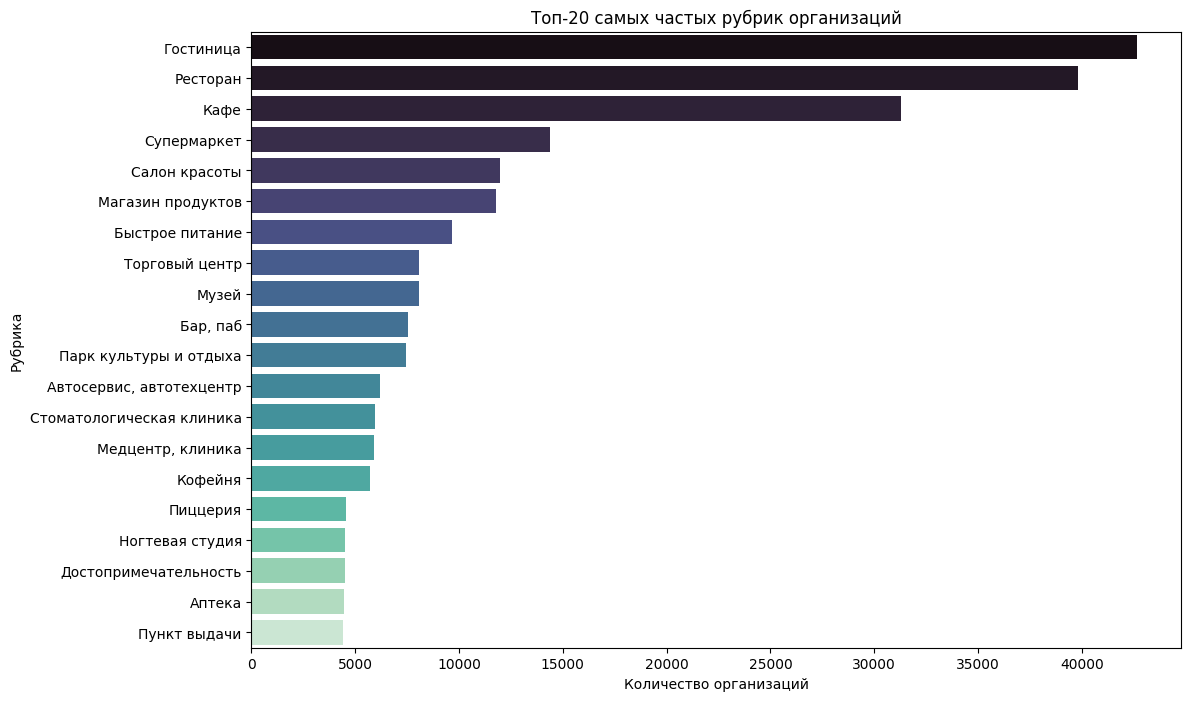

In [86]:
top_rubrics = df_rubrics['main_rubric'].value_counts().nlargest(20)
plt.figure(figsize=(12, 8))
sns.barplot(y=top_rubrics.index, x=top_rubrics.values, palette='mako', hue=top_rubrics.index)
plt.title('Топ-20 самых частых рубрик организаций')
plt.xlabel('Количество организаций')
plt.ylabel('Рубрика')
plt.show()

Топ изменился. Оставим для основного датасета преобразованное поле, где будет лист рубрик и новое поле с главной рубрикой

In [88]:
df['rubrics'] = df['rubrics'].str.split(';')
df['main_rubric'] = df['rubrics'].apply(lambda x: x[0])
df.head()

,address,name_ru,rating,rubrics,text,main_rubric
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.0,[Жилой комплекс],Московский квартал 2.\nШумно : летом по ночам ...,Жилой комплекс
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.0,"[Магазин продуктов, Продукты глубокой заморозк...","Замечательная сеть магазинов в общем, хороший ...",Магазин продуктов
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.0,[Фитнес-клуб],"Не знаю смутят ли кого-то данные правила, но я...",Фитнес-клуб
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0,"[Пункт проката, Прокат велосипедов, Сапсёрфинг]",Хорошие условия аренды. \nДружелюбный персонал...,Пункт проката
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0,"[Салон красоты, Визажисты, стилисты, Салон бро...",Топ мастер Ангелина топ во всех смыслах ) Немн...,Салон красоты


## Рейтинг

In [89]:
df['rating'].describe()

count    500000.00000
mean          4.48160
std           1.14625
min           0.00000
25%           5.00000
50%           5.00000
75%           5.00000
max           5.00000
Name: rating, dtype: float64

Видим, что большинство оценок положительного характера и при обучении стоит учесть дисбаланс классов

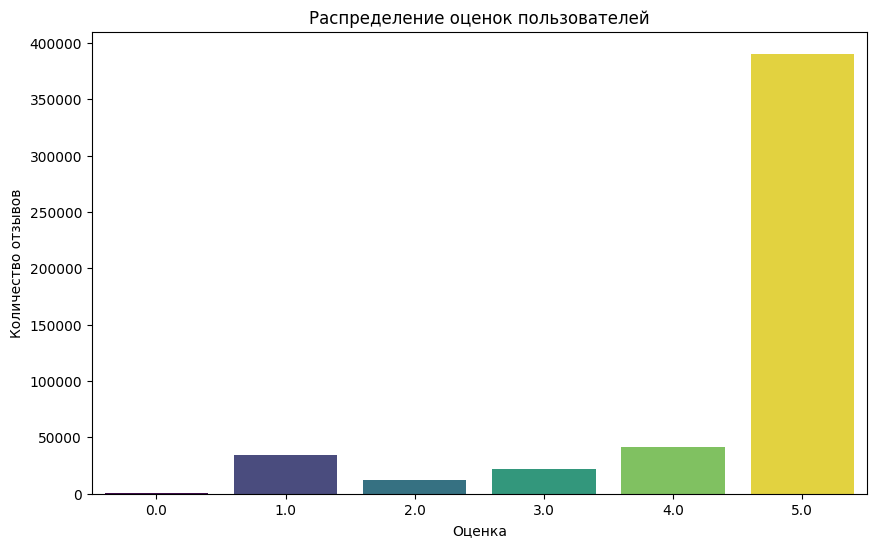

In [92]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df, palette='viridis', hue='rating', legend=False)
plt.title('Распределение оценок пользователей')
plt.xlabel('Оценка')
plt.ylabel('Количество отзывов')
plt.show()

## Отзывы

Сначала посмотрим, как вообще распределено количество отзывов по организациям, потому что нам будет сложно что-то сделать с организацией, где 1 отзыв

Сначала посмотрим группировку по названиям, так как организации могут иметь много филиалов (например Пятерочка) и некоторые отзывы могут быть в целом про органиазцию, а не на данные филиал